# Kütüphanelerin eklenmesi

In [1]:
#kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import sklearn.metrics as mt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

#modeller
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Verileri kaynağınan çekme ve Gözlemleme

In [2]:
#pandas ile .csv formatındaki veriyi okuyalım
veriler=pd.read_csv('medicaldataset.csv')
veriler.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,negative
1,20,1,94,98,46,296.0,6.75,1.060,positive
2,56,1,64,160,77,270.0,1.99,0.003,negative
3,66,1,70,120,55,270.0,13.87,0.122,positive
4,54,1,64,112,65,300.0,1.08,0.003,negative


Veri setinin özelliklerine göz atalım

In [3]:
print(f'Shape of data: {veriler.shape}\nNumber of Columns: {len(veriler.columns)}\nSize of Dataset: {veriler.size}')

Shape of data: (1319, 9)
Number of Columns: 9
Size of Dataset: 11871


In [4]:
veriler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [5]:
#veri setinin her sütununa ait özet bilgileri
veriler. describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.193328,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.638173,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


Her sutunda bulunan null veya eksik verileri gözlemleyelim

In [6]:
veriler.isna().sum()

Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

Her sütuna ait eşsiz tekrar etmeyen verilerin sayılarına bakalım

In [7]:
for col in veriler.columns:
    print('Unique data in', col, ':', veriler[col].value_counts().nunique())

Unique data in Age : 32
Unique data in Gender : 2
Unique data in Heart rate : 34
Unique data in Systolic blood pressure : 32
Unique data in Diastolic blood pressure : 38
Unique data in Blood sugar : 26
Unique data in CK-MB : 11
Unique data in Troponin : 26
Unique data in Result : 2


veri setini kopyalayalım ve tahmin edilecek bölümü ayıralım

In [8]:
cpVeriler=veriler.copy()
cpVeriler.pop('Result')
cpVeriler.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
0,63,1,66,160,83,160.0,1.80,0.012
1,20,1,94,98,46,296.0,6.75,1.060
2,56,1,64,160,77,270.0,1.99,0.003
3,66,1,70,120,55,270.0,13.87,0.122
4,54,1,64,112,65,300.0,1.08,0.003


daha önce sayısal veriye dönüştürülmüş cinsiyet alanını modelin anlayabilmesi için kategorig eriye çevirelim

In [9]:
def to_categorical(df):
    cat_columns = [
        'Gender',
    ]
    for i in cat_columns:
        df[i] = pd.Categorical(df[i])
    return df

In [10]:
to_categorical(cpVeriler).dtypes

Age                            int64
Gender                      category
Heart rate                     int64
Systolic blood pressure        int64
Diastolic blood pressure       int64
Blood sugar                  float64
CK-MB                        float64
Troponin                     float64
dtype: object

z-score kullanarak standart sapma ile aykırı verileri veri tabanından çıkaralım

In [11]:
def clear_outlier(df):
    for column in df.select_dtypes(exclude='category').columns:
        upper_limit = df[column].mean() + 3*df[column].std()
        lower_limit = df[column].mean() - 3*df[column].std()

        df[column] = np.where(
            df[column]>upper_limit,
            upper_limit,
            np.where(
                df[column]<lower_limit,
                lower_limit,
                df[column]
            )
        )
    return df

In [12]:
clear_outlier(cpVeriler)

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
0,63.0,1,66.0,160.0,83.0,160.000000,1.80,0.012000
1,20.0,1,94.0,98.0,46.0,296.000000,6.75,1.060000
2,56.0,1,64.0,160.0,77.0,270.000000,1.99,0.003000
3,66.0,1,70.0,120.0,55.0,270.000000,13.87,0.122000
4,54.0,1,64.0,112.0,65.0,300.000000,1.08,0.003000
...,...,...,...,...,...,...,...,...
1314,44.0,1,94.0,122.0,67.0,204.000000,1.63,0.006000
1315,66.0,1,84.0,125.0,55.0,149.000000,1.33,0.172000
1316,45.0,1,85.0,168.0,104.0,96.000000,1.24,3.824645
1317,54.0,1,58.0,117.0,68.0,371.403478,5.80,0.359000


# Veri Görselleştirme

Kalp krizi verilerinin pozitif ve negatif sonuçlarının birbirine oranına bakalım

([<matplotlib.patches.Wedge at 0x161e147ced0>,
 [Text(-0.38591652286076394, 1.0300817624747356, 'Positive'),
  Text(0.4209998431208328, -1.1237255590633481, 'Negative')],
 [Text(-0.21049992156041666, 0.561862779531674, '61%'),
  Text(0.24558324182048574, -0.6555065761202863, '39%')])

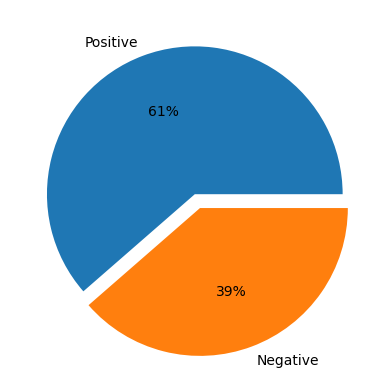

In [13]:
plt.pie(
    veriler['Result'].value_counts(),
    labels=['Positive', 'Negative'],
    explode=[0, 0.1],
    autopct='%.0f%%'
)

Veri seti içerisinde bulunan metinsel veriyi sayısal veriye dönüştürelim

In [14]:
le=preprocessing.LabelEncoder()
ohe=preprocessing.OneHotEncoder()

result=veriler.iloc[:,-1:].values
result[:,0]=le.fit_transform(veriler.iloc[:,-1])
result=ohe.fit_transform(result).toarray()
veri=veriler.iloc[:,0:8].values


In [15]:
data=pd.DataFrame(data=veri,index=range(1319),columns=['Age','Gender','Heart rate','Systolic blood pressure','Diastolic blood pressure','Blood sugar','CK-MB','Troponin'])
tahmindata=pd.DataFrame(data=result[:,-1],index=range(1319),columns=['Positive'])
tumVeri=pd.concat([data,tahmindata],axis=1)

tümverilerin bir tabloda birbirine oranına bakalım

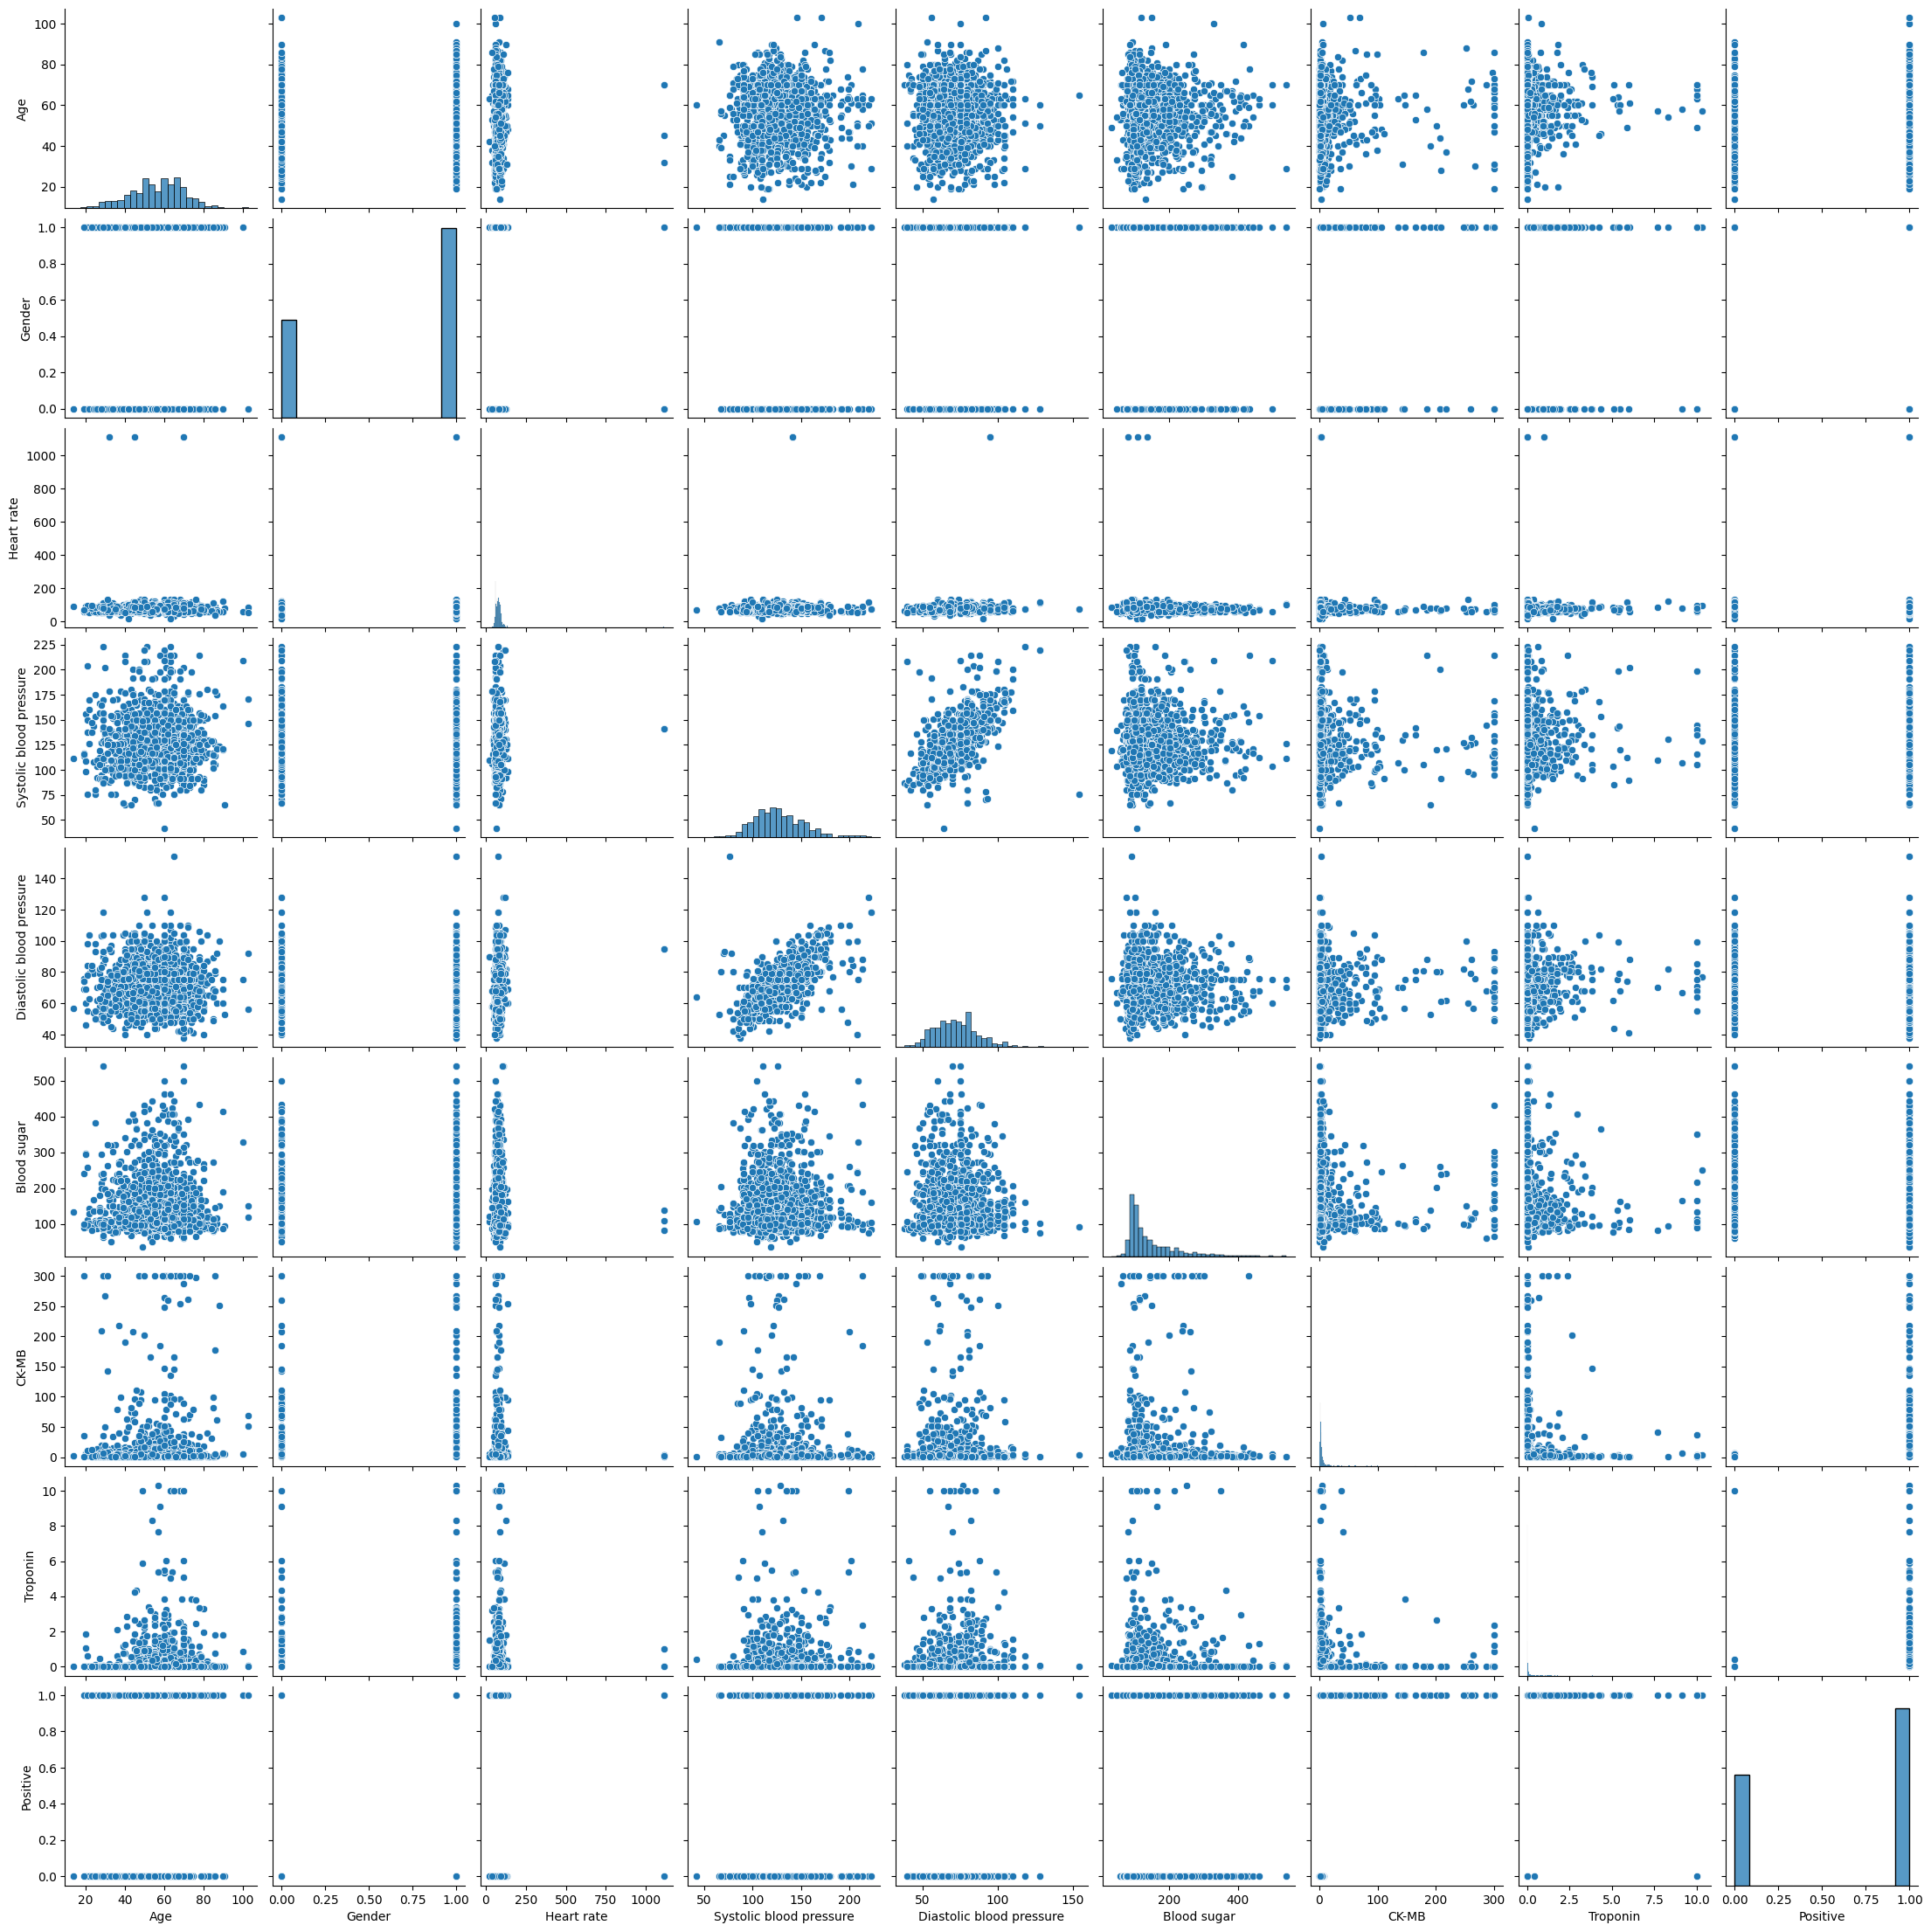

In [16]:
sns.pairplot(tumVeri)

<Axes: >

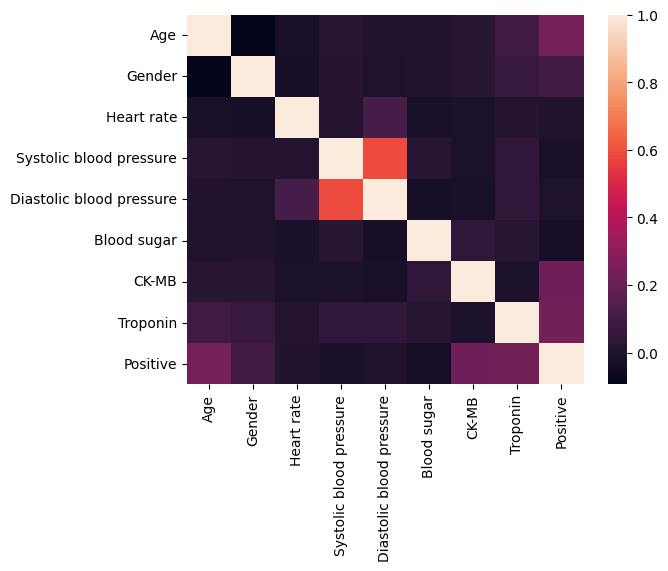

In [17]:
sns.heatmap(tumVeri.corr())

Hazırladığımız veri setine bir Pipeline kuralım. Bu pipeline ile verileri veri ön işleme, modeli eğitme sonuçları görüntüleme gibi adımları içerir.

# Pipeline

In [18]:
cat_cs = make_column_selector(dtype_include='category')

cat_ohe = preprocessing.OneHotEncoder(sparse_output=False, drop='if_binary').set_output(transform='pandas')
cat_pipeline = make_pipeline(cat_ohe)


num_cs = make_column_selector(dtype_exclude='category')

num_scl = preprocessing.StandardScaler().set_output(transform='pandas')
num_pipeline = make_pipeline(num_scl)

col_t = make_column_transformer(
    (num_pipeline, num_cs),
    (cat_pipeline, cat_cs)
)

In [19]:
preprocess = make_pipeline(
    preprocessing.FunctionTransformer(to_categorical),
    preprocessing.FunctionTransformer(clear_outlier),
    col_t
)

preprocess.set_output(transform='pandas')

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function to_categorical at 0x00000161E12CD3A0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function clear_outlier at 0x00000161E0DBF9C0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000161E922A690>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000161E93D2E90>)]))])

# Model Seçimi

Kulanmak istediğimiz modelleri hazırlayalım

In [20]:
X = tumVeri.copy()
y = X.pop("Positive")
print(tumVeri)

       Age  Gender  Heart rate  Systolic blood pressure  \
0     63.0     1.0        66.0                    160.0   
1     20.0     1.0        94.0                     98.0   
2     56.0     1.0        64.0                    160.0   
3     66.0     1.0        70.0                    120.0   
4     54.0     1.0        64.0                    112.0   
...    ...     ...         ...                      ...   
1314  44.0     1.0        94.0                    122.0   
1315  66.0     1.0        84.0                    125.0   
1316  45.0     1.0        85.0                    168.0   
1317  54.0     1.0        58.0                    117.0   
1318  51.0     1.0        94.0                    157.0   

      Diastolic blood pressure  Blood sugar  CK-MB  Troponin  Positive  
0                         83.0        160.0   1.80     0.012       0.0  
1                         46.0        296.0   6.75     1.060       1.0  
2                         77.0        270.0   1.99     0.003       0.0  

In [21]:
models = {
    "AdaBoost": {
        'model': AdaBoostClassifier()
    },
    "Random Forest": {
        'model': RandomForestClassifier(verbose=False)
    },
    "QDA": {
        'model': QuadraticDiscriminantAnalysis()
    },
    "Neural Net": {
        'model': MLPClassifier(verbose=False)
    },
    "RBF SVM": {
        'model': SVC(verbose=False)
    },
    "Gaussian Process": {
        'model': GaussianProcessClassifier()
    },
    "Linear SVM": {
        'model': SVC(kernel="linear", verbose=False)
    },
    "LGBM": {
        'model': LGBMClassifier(verbose=0)
    },
    "Decision Tree": {
        'model': DecisionTreeClassifier()
    },
    "CatBoost": {
        'model': CatBoostClassifier(verbose=False)
    },
    "Naive Bayes": {
        'model': GaussianNB()
    },
    "XGB": {
        'model': XGBClassifier()
    },
    "Nearest Neighbors": {
        'model': KNeighborsClassifier()
    }
}

Hazırladığımızı modellerin eğitim işlemini gerçekleştirelim.

In [22]:
for model in models:
    print('----------------------------------')
    print(f'{model} is training...')

    model_pipeline = make_pipeline(preprocess, models[model]['model'])
    scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
    
    models[model]['ACC'] = scores

----------------------------------
AdaBoost is training...


c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

----------------------------------
Random Forest is training...
----------------------------------
QDA is training...
----------------------------------
Neural Net is training...


c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

----------------------------------
RBF SVM is training...
----------------------------------
Gaussian Process is training...
----------------------------------
Linear SVM is training...
----------------------------------
LGBM is training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

Tüm modeller eğitildikten sonra hepsinin doğruluk değelerini hesaplayalım

In [23]:
for model in models:
    print('------------------------------------')
    print(f"{model}\nAccuracy CV 5: {models[model]['ACC']}\nAccuarcy Mean: {models[model]['ACC'].mean()}")

------------------------------------
AdaBoost
Accuracy CV 5: [0.96969697 0.98484848 0.98863636 0.98106061 0.99239544]
Accuarcy Mean: 0.9833275723009564
------------------------------------
Random Forest
Accuracy CV 5: [0.96590909 0.98863636 0.99242424 0.98863636 0.99619772]
Accuarcy Mean: 0.9863607558474479
------------------------------------
QDA
Accuracy CV 5: [0.90151515 0.71590909 0.73863636 0.70833333 0.71102662]
Accuarcy Mean: 0.7550841110727042
------------------------------------
Neural Net
Accuracy CV 5: [0.81060606 0.8219697  0.79545455 0.8219697  0.84410646]
Accuarcy Mean: 0.8188212927756654
------------------------------------
RBF SVM
Accuracy CV 5: [0.77272727 0.74242424 0.73484848 0.77272727 0.7756654 ]
Accuarcy Mean: 0.7596785343933632
------------------------------------
Gaussian Process
Accuracy CV 5: [0.71212121 0.71212121 0.70075758 0.72348485 0.74144487]
Accuarcy Mean: 0.7179859430810002
------------------------------------
Linear SVM
Accuracy CV 5: [0.82575758 0.80

Hesapladığımız doğrulukdeğerlerini bir dataframe olarak görüntüleyelim

In [24]:
plot_df = pd.DataFrame({'Model': [], 'ACC': []})
for model in models:
    plot_df.loc[len(plot_df.index)] = [model, models[model]['ACC'].mean()]

Doğruluk değerlerini bir sütun grafiği ile gösrel bir şekilde karşılaştıralım

C:\Users\musta\AppData\Local\Temp\ipykernel_6648\1364945723.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=45)


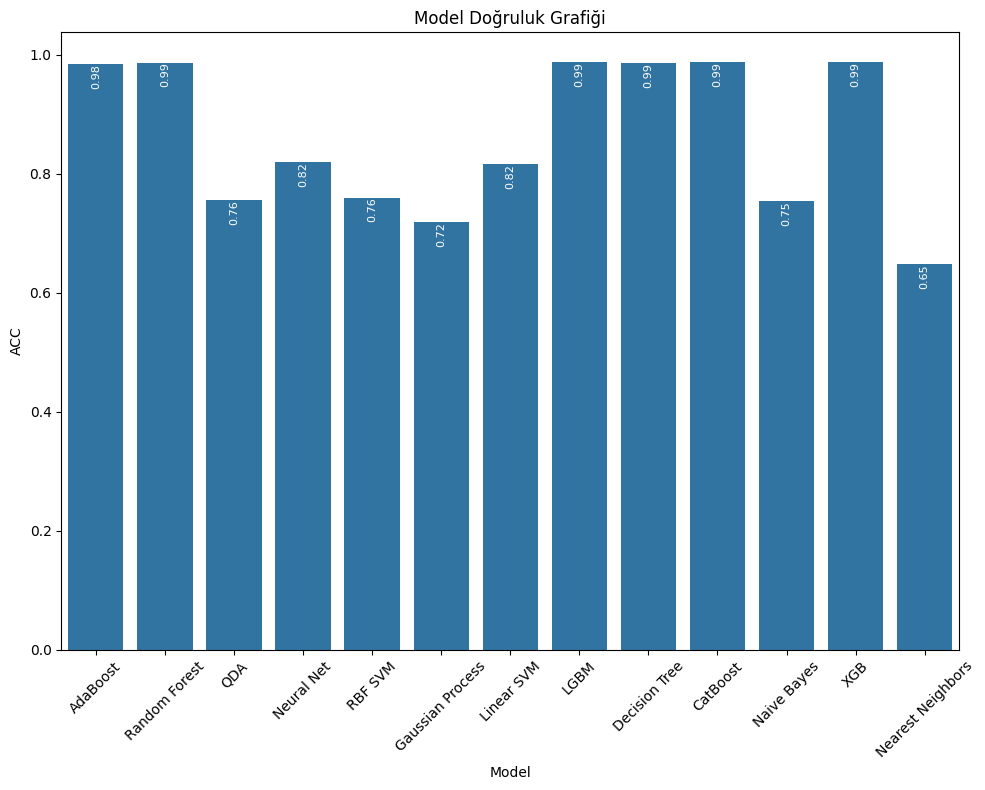

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

sns.barplot(x='Model', y='ACC', data=plot_df, ax=axs)
axs.set_title(f'Model Doğruluk Grafiği')
axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
for p in axs.patches:
    height = p.get_height()
    width = p.get_x() + p.get_width() / 2.
    axs.text(width, height, f'{height:.2f}', ha='center', va='top', rotation=90, fontsize=8, color='white')


plt.tight_layout()
plt.show()